In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from shapely.geometry import Point
import geopandas as gpd
import os
import random

In [2]:
# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

In [3]:
data.head()

,ds,Lat,Lon,y,unique_id,date,latitude,longitude,activity_index
0,2020-01-01,51.728440,7.333657,0.117984,1,2020-01-01,0.399589,0.344182,0.605971
1,2020-01-02,51.745312,7.324808,0.128913,1,2020-01-02,0.612946,0.244590,0.924800
2,2020-01-03,51.736941,7.322903,0.123177,1,2020-01-03,0.507084,0.223151,0.757461
3,2020-01-04,51.736578,7.307931,0.125445,1,2020-01-04,0.502494,0.054646,0.823631
4,2020-01-05,51.744239,7.330141,0.113853,1,2020-01-05,0.599377,0.304618,0.485474


In [4]:
# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 8  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

In [5]:
# Prepare the data for ConvLSTM
def prepare_data(data, include_target=True):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
        if include_target:
            y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    if include_target:
        y = np.array(y)
        return X, y
    return X, None

In [6]:
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Before reshaping:
X_train shape: (285, 7, 3)
X_test shape: (67, 7, 3)
After reshaping:
X_train shape: (285, 7, 1, 3, 1)
X_test shape: (67, 7, 1, 3, 1)


In [7]:
# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=2*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=4*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=8*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=16*n_filters, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    Dense(1)  # Output layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 7, 1, 3, 8)        320       
                                                                 
 batch_normalization (Batch  (None, 7, 1, 3, 8)        32        
 Normalization)                                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 7, 1, 3, 16)       1600      
                                                                 
 batch_normalization_1 (Bat  (None, 7, 1, 3, 16)       64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 7, 1, 3, 32)       6272      
                                                                 
 batch_normalization_2 (Bat  (None, 7, 1, 3, 32)       1

In [9]:
# Compile the model
batch_size = 32
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_test, y_test), verbose = 1)
# Define the filename with hyperparameters
filename = f"ConvLSTM_model_filters_{n_filters}_kernel_{kernel_size}_seq_{seq_length}_batch_size_{batch_size}.h5"

# Save the model
model.save(filename)


Epoch 1/25
9/9 [==============================] - 11s 146ms/step - loss: 0.6224 - val_loss: 0.1176
Epoch 2/25
9/9 [==============================] - 0s 36ms/step - loss: 0.2243 - val_loss: 0.0545
Epoch 3/25
9/9 [==============================] - 0s 36ms/step - loss: 0.1237 - val_loss: 0.0316
Epoch 4/25
9/9 [==============================] - 0s 37ms/step - loss: 0.0988 - val_loss: 0.0318
Epoch 5/25
9/9 [==============================] - 0s 37ms/step - loss: 0.0766 - val_loss: 0.0389
Epoch 6/25
9/9 [==============================] - 0s 40ms/step - loss: 0.0554 - val_loss: 0.0429
Epoch 7/25
9/9 [==============================] - 0s 37ms/step - loss: 0.0510 - val_loss: 0.0453
Epoch 8/25
9/9 [==============================] - 0s 37ms/step - loss: 0.0441 - val_loss: 0.0449
Epoch 9/25
9/9 [==============================] - 0s 38ms/step - loss: 0.0434 - val_loss: 0.0452
Epoch 10/25
9/9 [==============================] - 0s 36ms/step - loss: 0.0408 - val_loss: 0.0464
Epoch 11/25
9/9 [==========

C:\Users\janak\anaconda3\envs\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


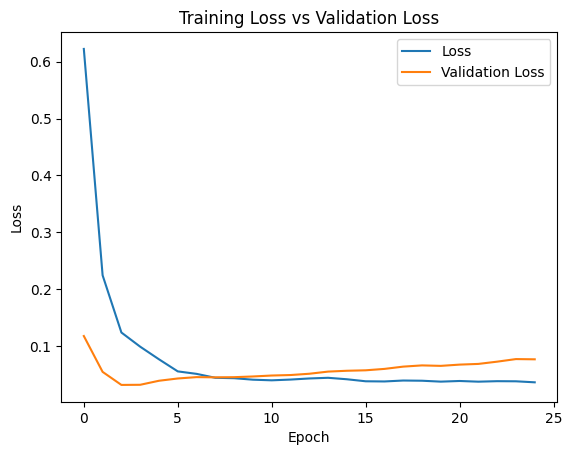

In [10]:
# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test)#.reshape(-1)
y_pred = y_pred[:, 0, 0]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

3/3 [==============================] - 0s 5ms/step - loss: 0.0766
Test Loss: 0.07660413533449173
3/3 [==============================] - 1s 6ms/step
0.0757064318631233 -1.5519604273011307


In [12]:
#y_pred = y_pred[:, 0]
y_pred[:,0].shape, y_test.shape, y_pred[:,0]

((67,),
 (67,),
 array([0.65856117, 0.6586102 , 0.6580751 , 0.6571912 , 0.6567428 ,
        0.6563841 , 0.65686893, 0.6566865 , 0.6567116 , 0.6556387 ,
        0.65470874, 0.65365124, 0.6539041 , 0.65408814, 0.6539999 ,
        0.6540791 , 0.6543245 , 0.6546651 , 0.65436435, 0.65342236,
        0.653239  , 0.6549768 , 0.6574993 , 0.6585564 , 0.65651447,
        0.6545785 , 0.6533712 , 0.65494525, 0.6575031 , 0.6561506 ,
        0.650874  , 0.64576226, 0.6424804 , 0.64005375, 0.64531153,
        0.65462416, 0.6534008 , 0.65165615, 0.65370685, 0.6606533 ,
        0.6612694 , 0.6607163 , 0.6593339 , 0.65673107, 0.6561552 ,
        0.6545459 , 0.65134454, 0.6477837 , 0.64836997, 0.6518295 ,
        0.6582472 , 0.6600349 , 0.6607845 , 0.6598834 , 0.6594689 ,
        0.6602096 , 0.6602906 , 0.66091204, 0.65749145, 0.6565324 ,
        0.64685965, 0.64495146, 0.6426588 , 0.64388365, 0.6445414 ,
        0.6463421 , 0.649112  ], dtype=float32))

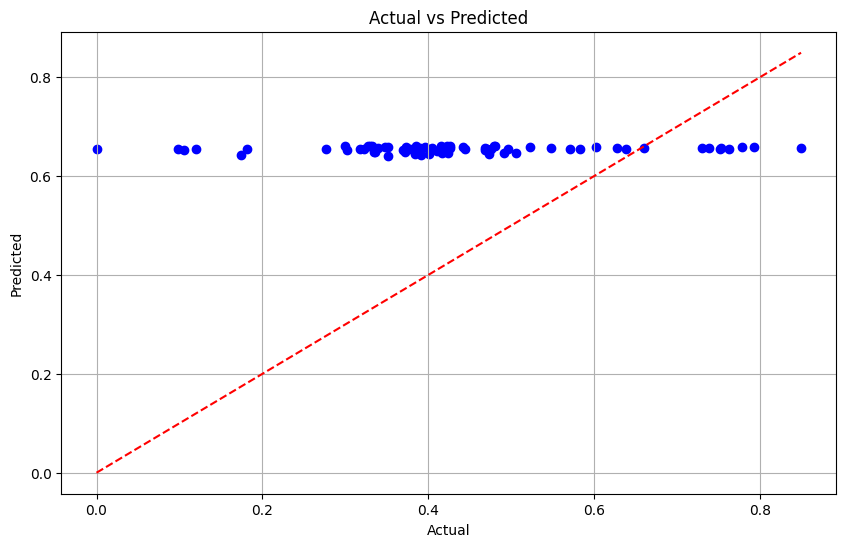

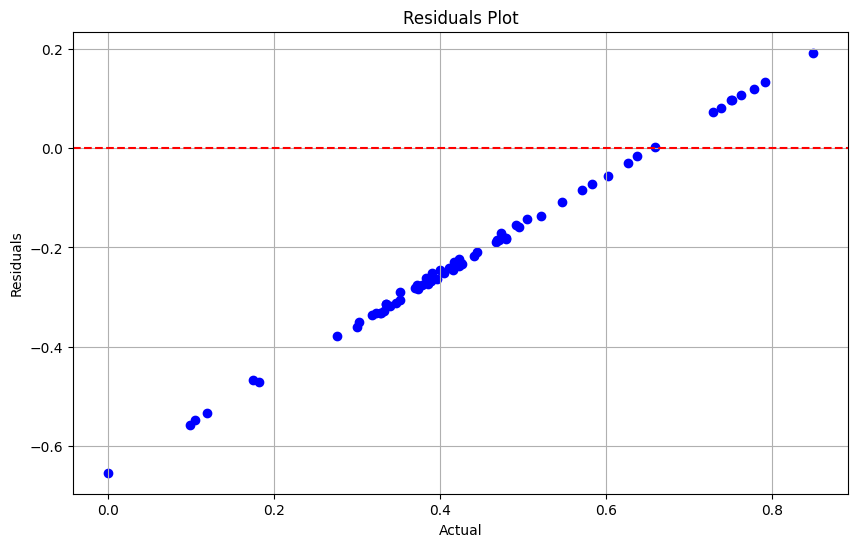

In [13]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred[:,0], color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [14]:
# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Index': y_test, 'Pred_Index': y_pred[:,0],
                        'Latitude': test_data['Lat'][-len(y_test):].values,
                        'Longitude': test_data['Lon'][-len(y_test):].values,
                        'Date': test_data['date'][-len(y_test):].dt.strftime('%Y-%m-%d')})  # Convert datetime to string
test_df.to_csv('test_pred_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

C:\Users\janak\anaconda3\envs\python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\janak\AppData\Local\Temp\ipykernel_8408\877578966.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('test_predicted_values.shp')


In [19]:
# Generate random data for prediction
random_data = pd.DataFrame({
    'date': pd.date_range(start='2020-11-01', end='2020-12-31'),
    'latitude': np.random.uniform(low=data['Lat'].min(), high=(data['Lat'].max()), size=(61,)),
    'longitude': np.random.uniform(low=(data['Lon'].min()), high=(data['Lon'].max()), size=(61,))
})
n_features = 2
# Normalize the random data
random_data['latitude'] = (random_data['latitude'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
random_data['longitude'] = (random_data['longitude'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
random_data['activity_index'] = np.nan  # Placeholder for activity index

# Prepare random data for prediction
X_random, _ = prepare_data(random_data, include_target=False)
X_random = X_random.reshape(-1, seq_length, 1, n_features, 1)



In [21]:
X_random

array([[[[[3.83102802e-01],
          [1.56599439e-01]]],


        [[[           nan],
          [3.10773502e-01]]],


        [[[6.33724734e-01],
          [           nan]]],


        ...,


        [[[           nan],
          [6.18394025e-01]]],


        [[[6.97757974e-01],
          [           nan]]],


        [[[1.32988972e-01],
          [4.07185731e-01]]]],



       [[[[           nan],
          [7.57239033e-01]]],


        [[[2.51207513e-01],
          [           nan]]],


        [[[2.96319670e-01],
          [7.71285253e-01]]],


        ...,


        [[[6.33724734e-01],
          [           nan]]],


        [[[9.36554763e-01],
          [9.56237562e-01]]],


        [[[           nan],
          [6.18394025e-01]]]],



       [[[[6.97757974e-01],
          [           nan]]],


        [[[1.32988972e-01],
          [4.07185731e-01]]],


        [[[           nan],
          [7.57239033e-01]]],


        ...,


        [[[2.96319670e-01],
          [7.71285253e-

In [28]:
# Make predictions on random data
y_random_pred = model.predict(X_random)#.reshape(-1)

3/3 [==============================] - 0s 4ms/step


In [37]:
y_random_pred = y_random_pred[:,0]
y_random_pred

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32)

In [38]:


# Combine random data with predicted values
random_pred_df = pd.DataFrame({
    'Pred_Index': y_random_pred,
    'Latitude': random_data['latitude'].values[-len(y_random_pred):],
    'Longitude': random_data['longitude'].values[-len(y_random_pred):],
    'Date': random_data['date'].dt.strftime('%Y-%m-%d')[-len(y_random_pred):]
})

# Save random data and predicted values to CSV
random_pred_df.to_csv('random_pred_values.csv', index=False)

# Convert random data CSV to shapefile
geometry_random = [Point(xy) for xy in zip(random_pred_df['Longitude'], random_pred_df['Latitude'])]
gdf_random = gpd.GeoDataFrame(random_pred_df, geometry=geometry_random)
gdf_random.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf_random.to_file('random_predicted_values.shp')


ValueError: All arrays must be of the same length

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from shapely.geometry import Point
import geopandas as gpd
import os
import random

# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

# Prepare the data for ConvLSTM
def prepare_data(data):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
        y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1,  n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=64, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=128, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=256, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=512, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    Dense(1)  # Output layer
])


# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test).reshape(-1)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': test_data['Lat'][-len(y_test):].values,
                        'Longitude': test_data['Lon'][-len(y_test):].values,
                        'Date': test_data['date'][-len(y_test):].values})
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

# Generate random data for prediction
random_data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', end='2023-01-10'),
    'Lat': np.random.uniform(low=data['Lat'].min(), high=data['Lat'].max(), size=(10,)),
    'Lon': np.random.uniform(low=data['Lon'].min(), high=data['Lon'].max(), size=(10,))
})

# Prepare random data for prediction
X_random, _ = prepare_data(random_data)
X_random = X_random.reshape(-1, seq_length, 1, n_features, 1)

# Make predictions on random data
y_random_pred = model.predict(X_random).reshape(-1)

# Combine random data with predicted values
random_pred_df = pd.DataFrame({'Predicted_Activity_Index': y_random_pred,
                               'Latitude': random_data['Lat'].values,
                               'Longitude': random_data['Lon'].values,
                               'Date': random_data['Date'].values})

# Save random data and predicted values to CSV
random_pred_df.to_csv('random_predicted_values.csv', index=False)

# Convert random data CSV to shapefile
geometry_random = [Point(xy) for xy in zip(random_pred_df['Longitude'], random_pred_df['Latitude'])]
gdf_random = gpd.GeoDataFrame(random_pred_df, geometry=geometry_random)
gdf_random.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf_random.to_file('random_predicted_values.shp')
